# Word2Vec 이란 ?

말 그대로 Word(단어)를 to(2) Vector (벡터)로 나타내는 것

가장 널리 사용되고 있는 임베딩 방법중의 하나!!
- 임베딩(embedding) : 사람이 쓰는 자연어를 기계가 이해할 수 있는 숫자인 벡터로 나타나는 결과나 과정을 의미, 벡터가 아닌 것을 고정 길이의 벡터로 나타내는 것

특정 단어 양 옆에 있느 두 단어의 관계를 활용하기 때문에 분포가설을 잘 반영하고 있음
- 분포가설 : '비슷한 위치에서 등장하는 단어들은 비슷한 의미를 가지고 있다'라는 가정을 기반하여 주변 단어 분포를 기준으로 단어의 벡터 표현이 결정되기 때문에 분산표현 (Distributed Representation)이라고 부름

자연어 처리뿐만 아니라 추천시스템에서도 자주 사용

In [1]:
!pip install konlpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 9.5 MB/s eta 0:00:00


In [32]:
# 필요한 리이브러리 불러오기

import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt

In [3]:
# 네이버 영화 리뷰 데이터를 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt",
                           filename="ratings.txt")

('ratings.txt', <http.client.HTTPMessage at 0x7861bfde5c30>)

In [19]:
# 데이터를 데이터프레임으로 불러오기
train_data = pd.read_table('ratings.txt')

In [20]:
train_data.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [21]:
# 총 리뷰 갯수 확인
print(len(train_data))

200000


In [22]:
# 총 20만개의 데이터 샘플이 있음 => 결측값 유무를 확인해봐야 함!
print(train_data.isnull().values.any())

# any() : 하나라도 True인게 있으면 True
# all() : 모두 True여야 True 반환

True


In [23]:
# 결측값이 존재하므로 결측값이 존재하는 행 제거하기

train_data = train_data.dropna(how = 'any') # 결측값이 존재하는 행 제거
# 'any' : 존재하면 제거 / 'all' : 모두 결측치면 제거

print(train_data.isnull().values.any())
# 결과로 False가 나온것이 확인됨 => 결측값이 사라졌음

False


In [24]:
# 결측값이 삭제된 후의 리뷰 갯수 확인
print(len(train_data))

199992


In [27]:
# 총 199,992개의 리뷰가 존재
# 정규 표현식을 통해 한글이 아닌 경우 내용을 없애는 전처리
# replace함수의 regex=True라는 옵션을 통해 정규 표현식을 사용했음을 알려줘야 하고,
# 공백문자 \s 까지 추가해서 띄어쓰기에 대한 내용은 처리하지 않도록 함
train_data['document'] = train_data['document'].str.replace("[^ㄱ-하-ㅣ가-힣0-9]", "", regex=True)

In [28]:
train_data.head()

,id,document,label
0,8112052,어릴때보고지금다시봐도재밌어요ㅋㅋ,1
1,8132799,디자인을배우는학생으로외국디자이너와그들이일군전통을통해발전해가는문화산업이부러웠는데사실우...,1
2,4655635,폴리스스토리시리즈는1부터뉴까지버릴께하나도없음최고,1
3,9251303,와연기가진짜개쩔구나지루할거라고생각했는데몰입해서봤다그래이런게진짜영화지,1
4,10067386,안개자욱한밤하늘에떠있는초승달같은영화,1


In [29]:
# 불용어 제거

# 불용어 정의
stopwords = ['의', '가', '이', '은', '들', '는', '좀', '걍', '과', '도', '를',
             '으로', '자', '에', '와', '한', '하다']

okt = Okt()

tokenized_data = []
for sentence in train_data['document']:
  tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화 (stem=True : 동사의 원형)
  # 불용어 제거
  stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords]
  tokenized_data.append(stopwords_removed_sentence)

리뷰의 최대 길이 :  68
리뷰의 평균 길이 :  10.538701548061923


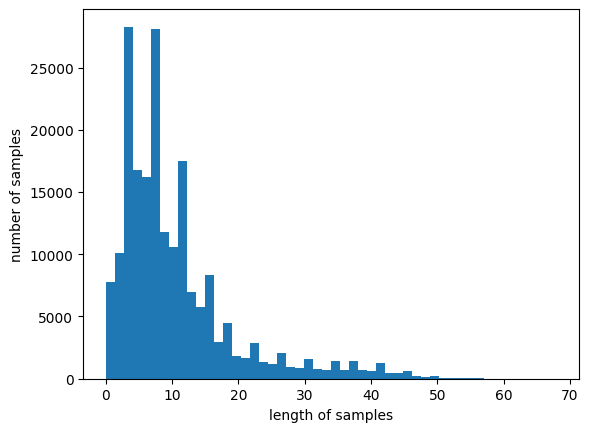

In [30]:
# 토큰화가 된 상태에서 각 리뷰의 길이 분포를 확인

print('리뷰의 최대 길이 : ', max(len(review) for review in tokenized_data))
print('리뷰의 평균 길이 : ', sum(map(len, tokenized_data)) / len(tokenized_data))
plt.hist([len(review) for review in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [33]:
# Word2Vec으로 토큰화 된 데이터를 학습

model = Word2Vec(sentences = tokenized_data, vector_size = 100,
                 window = 5, min_count = 5, workers = 4, sg = 0)

# 하이퍼파라미터 : 머신러닝의 모델에 대해 직접 설정할 수 있는 옵션
#     모델의 성능과 학습속도에 영향을 미침

# vector_size : 임베딩 된 벡터의 차원
# window : context window 크기, ( 현재 단어와 예측 단어 간의 거리)
# min_count : 단어 최소 빈도 수 제한 (빈도가 적은 단어들은 학습하지 않는다)
# workers : 학습을 위한 프로세스 수
# sg : 알고리즘 지정 / 0 : Continuous Bag of Word (CBOW), 1 : Skip-gram
#   CBOW : 주변 단어들의 정보를 통해 중심 단어를 예측하는 방법
#   Skip-gram : 하나의 단어에서 여러 단어들을 예측하는 방법

In [34]:
# Word2Vec 임베딩 행렬의 크기 확인
model.wv.vectors.shape

(17907, 100)

In [35]:
# 총 16,842개의 단어가 존재, 각 단어는 100차원으로 구성되어 있음
# '최민식' 과 유사한 단어 찾기
# model.wv.most_similar() 함수를 통해 해당 단어와 유사하다고 판별한 단어를 뽑아낼 수 있음
print(model.wv.most_similar('최민식'))

for i in model.wv.most_similar('최민식'):
  print("유사도 : " + i[0] + ", {:.2f}".format(i[1] * 100) + "%")

[('양동근', 0.8784183859825134), ('이정재', 0.8762481808662415), ('한석규', 0.8751120567321777), ('박신양', 0.8634008169174194), ('최민수', 0.8598257303237915), ('박중훈', 0.8518353700637817), ('김윤석', 0.8506776094436646), ('김수현', 0.8439744114875793), ('안성기', 0.8411824107170105), ('안소니', 0.8395070433616638)]
유사도 : 양동근, 87.84%
유사도 : 이정재, 87.62%
유사도 : 한석규, 87.51%
유사도 : 박신양, 86.34%
유사도 : 최민수, 85.98%
유사도 : 박중훈, 85.18%
유사도 : 김윤석, 85.07%
유사도 : 김수현, 84.40%
유사도 : 안성기, 84.12%
유사도 : 안소니, 83.95%


In [37]:
# '히어로'와 유사한 단어들을 뽑기
print(model.wv.most_similar('히어로'))

# wv.most_similar() 함수는 positive, negative 파라미터를 통해서
#   무협 + 정통 - 로코
#   (무협.정통이면서 로코가 아닌)
print(model.wv.most_similar(positive=['무협', '정통'], negative='로코'))

[('호러', 0.8590065836906433), ('느와르', 0.8574011921882629), ('블록버스터', 0.8452991247177124), ('무협', 0.8277283906936646), ('물', 0.8263028264045715), ('무비', 0.7995674014091492), ('슬래셔', 0.7857175469398499), ('정통', 0.779841959476471), ('홍콩', 0.7759670615196228), ('물의', 0.7753778696060181)]
[('첩보', 0.8008683323860168), ('헐리우드', 0.7682363390922546), ('애로', 0.7563683390617371), ('싸구려', 0.7551724910736084), ('물의', 0.75065016746521), ('느와르', 0.7423733472824097), ('홍콩', 0.7403806447982788), ('단순', 0.7350015044212341), ('블록버스터', 0.7209901809692383), ('호러', 0.720691978931427)]
